In [2]:
import os
from collections import defaultdict
import statistics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tools.utils.settings import DefaultPath as defpath
from tools.utils.utils import get_mongodb_collections

In [2]:
test_name = 'bigtest'

In [3]:
small = True
mongoclient, collections = get_mongodb_collections(small)

In [4]:
test_dir = defpath.data_path.josie_tests + '/' + test_name
results_dir = test_dir + '/results/extracted'
images_tables_dir = test_dir + '/images_tables'

In [40]:
columns=[
    'query_id', 
    'result_id',
    'algorithm',
    'mode',
    'query_size',
    'max_table_overlap_size',
    'rank', 
    'algorithm_overlap', 
    'sloth_overlap', 
    'difference_overlap',
    'difference_overlap_norm'
    ]

results = pd.DataFrame(columns=columns)

p = 10
algorithms = ['josie', 'lshforest']

In [11]:
modes = ['set', 'bag']

solvers = []

for algorithm in algorithms:
    for mode in modes:
        fname = f"{results_dir}/a{algorithm}_m{mode}_k{p}_extracted.csv"

        if not os.path.exists(fname):
            continue

        solvers.append((algorithm, mode))
        results = pd.concat([results, pd.read_csv(fname)])

/tmp/ipykernel_78260/57617968.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.read_csv(fname)])


In [42]:
lsh256_16 = pd.read_csv('/data4/nanni/tesi-magistrale/data/josie-tests/lsh_256_16/results/extracted/alshforest_mset_k10_extracted.csv')
lsh512_16 = pd.read_csv('/data4/nanni/tesi-magistrale/data/josie-tests/lsh_512_16/results/extracted/alshforest_mset_k10_extracted.csv')
lsh512_32 = pd.read_csv('/data4/nanni/tesi-magistrale/data/josie-tests/lsh_512_32/results/extracted/alshforest_mset_k10_extracted.csv')

lsh256_16['mode'] = lsh256_16['mode'] + '_256'
lsh512_16['mode'] = lsh512_16['mode'] + '_512_16'
lsh512_32['mode'] = lsh512_32['mode'] + '_512_32'


josie_set = pd.read_csv('/data4/nanni/tesi-magistrale/data/josie-tests/bigtest/results/extracted/ajosie_mset_k10_extracted.csv')

results = pd.concat([lsh256_16, lsh512_16, lsh512_32, josie_set])

In [43]:
results

,query_id,result_id,algorithm,mode,query_size,max_table_overlap_size,rank,algorithm_overlap,sloth_overlap,difference_overlap,difference_overlap_norm
0,183504,1036002,lshforest,set_256,58,162,1,10,8,2,0.012346
1,183504,106412,lshforest,set_256,58,162,2,2,3,-1,-0.006173
2,183504,1635471,lshforest,set_256,58,162,3,5,8,-3,-0.018519
3,183504,183505,lshforest,set_256,58,162,4,33,31,2,0.012346
4,183504,2154773,lshforest,set_256,58,162,5,2,1,1,0.006173
...,...,...,...,...,...,...,...,...,...,...,...
2025,170197,374269,josie,set,11,20,6,10,9,1,0.050000
2026,170197,170196,josie,set,11,20,7,10,10,0,0.000000
2027,170197,294503,josie,set,11,20,8,10,10,0,0.000000
2028,170197,503089,josie,set,11,20,9,9,9,0,0.000000


## Quanto sono validi i vari metodi? - Tasso di nullità

We define the Nullity Ratio the ratio for each query of retrivied IDs which actually have an overlap over a certain thresholds and the retrivied set size 

In [44]:
nullity_threshold = 0   # if the actual overlap between two tables isprint(next(resgroup)) under this threshold, the result is considered bad

x = []
for am, am_group in results.groupby(by=["algorithm", "mode"]):
    for query_id, q_group in am_group.groupby(by=["query_id"]):
        cnt = ((q_group['sloth_overlap'] <= nullity_threshold) & (q_group['difference_overlap'] <= nullity_threshold)).sum()
        num_query_results = q_group.count().values.tolist()[0]
        x.append([am[0], am[1], query_id[0], num_query_results, cnt, cnt / num_query_results])

x = pd.DataFrame(x, columns=['algorithm', 'mode', 'query_id', 'query_size', 'zero_overlap_cnt', 'zero_overlap_ratio'])

null_ratio_pivot = pd.pivot_table(x, values=['zero_overlap_ratio'], index=['algorithm', 'mode'], aggfunc=['mean', 'std', 'min', 'max'])
null_ratio_pivot

mean                std                min  \
                     zero_overlap_ratio zero_overlap_ratio zero_overlap_ratio   
algorithm mode                                                                  
josie     set                  0.000000           0.000000                0.0   
lshforest set_256              0.000594           0.008125                0.0   
          set_512_16           0.001773           0.013961                0.0   
          set_512_32           0.000585           0.008061                0.0   

                                    max  
                     zero_overlap_ratio  
algorithm mode                           
josie     set                  0.000000  
lshforest set_256              0.111111  
          set_512_16           0.111111  
          set_512_32           0.111111

## Algorithm vs True Overlap

In [45]:
data = [(am[0], am[1], group[(group['sloth_overlap'] != 0) & (group['difference_overlap'] != 0)]) for am, group in results.groupby(by=['algorithm', 'mode'])]

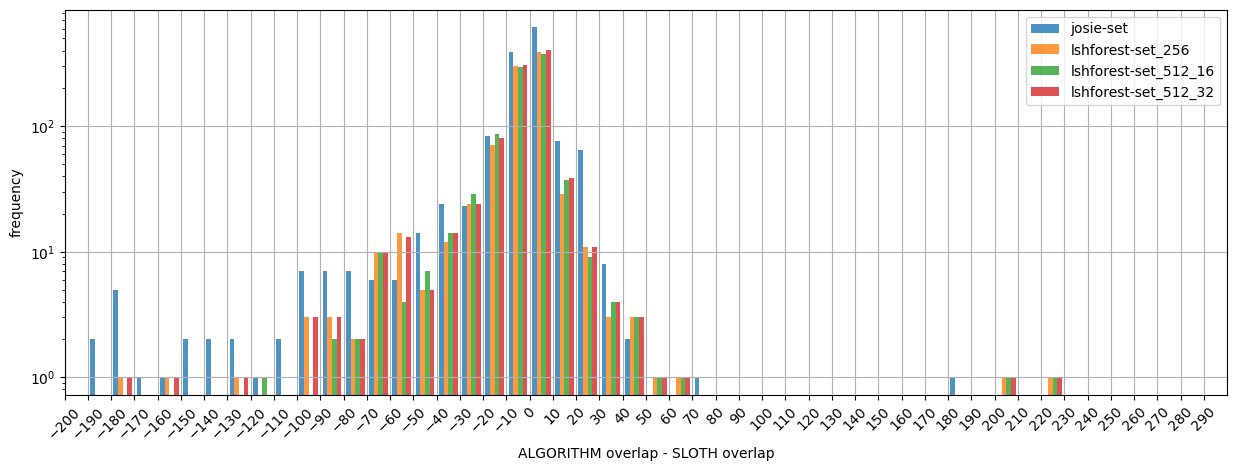

In [46]:
fig, ax = plt.subplots(1, 1, sharey='row', figsize=(15, 5))
xmin, xmax, step = -200, 300, 10

ax.hist([d[2]['difference_overlap'] for d in data], 
         bins=np.arange(xmin, xmax, step), alpha=0.8, 
         label=[f'{a}-{m}' for a, m, _ in data],
         align='mid')
ax.set_xlim(xmin, xmax)
ax.set_xticks(np.arange(xmin, xmax, step))
ax.set_yscale('log')
ax.tick_params(axis='x', rotation=45)
ax.grid()
ax.set_xlabel('ALGORITHM overlap - SLOTH overlap')
ax.set_ylabel('frequency')

plt.legend()
plt.show()

In [47]:
results['boh'] = results['algorithm_overlap'] / (results['sloth_overlap'] + 1)

In [48]:
data = [(am[0], am[1], group[(group['sloth_overlap'] != 0) & (group['difference_overlap'] != 0)]) for am, group in results.groupby(by=['algorithm', 'mode'])]

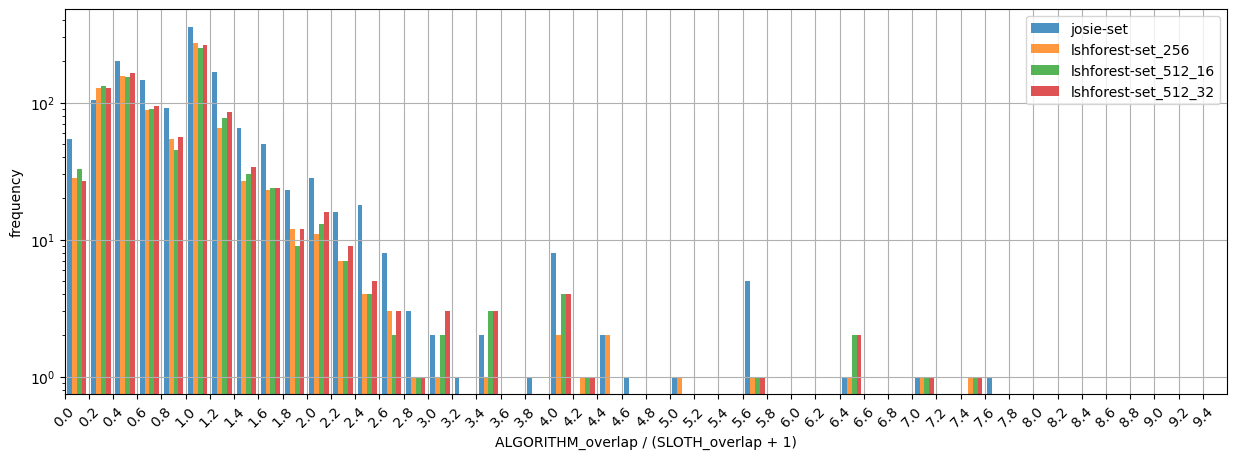

In [49]:
fig, ax = plt.subplots(1, 1, sharey='row', figsize=(15, 5))
xmin, xmax, step = 0, 9.6, 0.2

ax.hist([d[2]['boh'] for d in data], 
         bins=np.arange(xmin, xmax, step), alpha=0.8, 
         label=[f'{a}-{m}' for a, m, _ in data],
         align='mid')
ax.set_xlim(xmin, xmax)
ax.set_xticks(np.arange(xmin, xmax, step))
ax.grid()
ax.set_xlabel('ALGORITHM_overlap / (SLOTH_overlap + 1)')
ax.set_ylabel('frequency')
ax.set_yscale('log')
ax.tick_params(axis='x', rotation=45)
plt.legend()
plt.show()

## Creating Silver Standard

In [50]:
silver_standard = defaultdict(set)

results_ids = results.convert_dtypes().groupby(by='query_id')[['result_id', 'sloth_overlap']]

for query_id, ids_overlaps in results_ids:
    for i in ids_overlaps.values:
        _id, _overlap = i
        silver_standard[query_id].add((_id, _overlap))

for query_id in silver_standard.keys():
    silver_standard[query_id] = sorted(list(silver_standard[query_id]), key=lambda x: x[1], reverse=True)

## Precision at p - $P@p$
Corresponds to the number of relevant results among the top $p$ retrieved documents. Fails to take into account the positions of the relevant documents among the top $p$.Another shortcoming is that on a query with fewer relevant results than $p$, even a perfect system will have a score less than 1.


In [51]:
k_precisions = [1, 3, 5, 10]

precision_at_k_results = []

for query_id in silver_standard.keys():
    qss = [x[1] for x in silver_standard[query_id]]
    avg_overlap = round(statistics.mean(qss), 3)
    stdev_overlap = round(statistics.stdev(qss))

    for (algorithm, mode), data in results.groupby(by=["algorithm", "mode"]):
        ids = data[data['query_id'] == query_id]['result_id'].values.tolist()
        for k_precision in k_precisions:
            real_topk = [x[0] for x in silver_standard[query_id][:k_precision]]
            precision_at_k = set(real_topk).intersection(ids)
            
            precision_at_k_results.append([query_id, len(qss), avg_overlap, stdev_overlap, algorithm, mode, k_precision, len(precision_at_k)])

columns = [
    'query_id',
    'silver_std_size',
    'silver_std_ov_mean',
    'silver_std_ov_stdev',
    'algorithm',
    'mode',
    'k',
    'precision_at_k'
]

precision_at_k_results = pd.DataFrame(precision_at_k_results, columns=columns)
precision_at_k = precision_at_k_results.sort_values(by=['silver_std_size', 'query_id'], ascending=False)
# precision_at_k

In [52]:
patk_pivot = pd.pivot_table(precision_at_k, values=['precision_at_k'], index=['algorithm', 'mode'], columns=['k'], aggfunc=['mean', 'std', 'max'])
patk_pivot

mean                                \
                     precision_at_k                                 
k                                1         3         5         10   
algorithm mode                                                      
josie     set              0.516539  1.549618  2.582697  5.165394   
lshforest set_256          0.379135  1.033079  1.704835  3.307888   
          set_512_16       0.384224  1.096692  1.781170  3.282443   
          set_512_32       0.404580  1.127226  1.844784  3.524173   

                                std                                \
                     precision_at_k                                 
k                                1         3         5         10   
algorithm mode                                                      
josie     set              0.500363  1.501090  2.501817  5.003634   
lshforest set_256          0.485790  1.262256  2.048992  3.775507   
          set_512_16       0.487031  1.278078  2.057329  3.731980   
          set_512_32       0.491436  1.307005  2.115017  3.860455   

                                max            
                     precision_at_k            
k                                1  3  5   10  
algorithm mode                                 
josie     set                     1  3  5  10  
lshforest set_256                 1  3  5   9  
          set_512_16              1  3  5   9  
          set_512_32              1  3  5   9

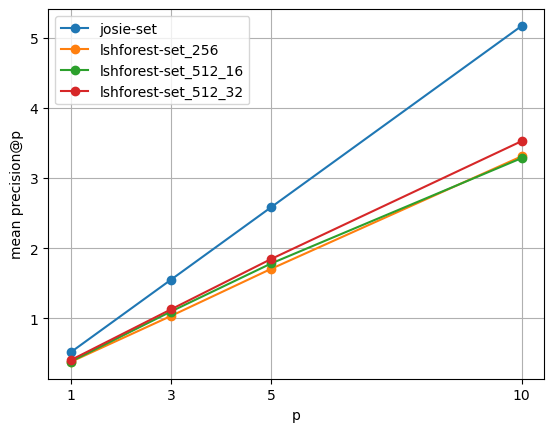

In [54]:
for row, label in zip(patk_pivot['mean', 'precision_at_k'].values, patk_pivot.index):
    plt.plot([1, 3, 5, 10], row, 'o-', label=f'{label[0]}-{label[1]}')
plt.xticks([1, 3, 5, 10], [1, 3, 5, 10])
plt.xlabel('p')
plt.ylabel('mean precision@p')
plt.legend()
plt.grid()

## Normalized Discontinued Cumulative Gain - $nDCG@p$

Search result lists vary in length depending on the query. Comparing a search engine's performance from one query to the next cannot be consistently achieved using DCG alone, so the cumulative gain at each position for a chosen value of $ p $ should be normalized across queries. This is done by sorting all relevant documents in the corpus by their relative relevance, producing the maximum possible DCG through position $p$, also called Ideal DCG (IDCG) through that position. For a query, the normalized discounted cumulative gain, or nDCG, is computed as: 

$ nDCG_{p} = {DCG_{p} \over IDCG_{p}} $

where $ IDCG_{p} $ is the ideal discounted cumulative gain,

$ IDCG_{p} = \sum_{i=1}^{|REL_{p}|} {2^{rel_{i}} - 1 \over log_{2}(i + 1)}$

where $ REL_{p} $ represents the list of relevant documents (ordered by their relevance) in the corpus up to position $p$

In [26]:
from math import log2

def ndcg_at_p(true_relevances, scores, p):
    p = min(p, len(true_relevances), len(scores))
    if p <= 0: # because computing nDCG is meaningful only if there is more than one document 
        return 0, 1
    idcg = sum(rel / log2(i + 1) for i, rel in enumerate(true_relevances[:p], start=1))
    dcg = sum(rel / log2(i + 1) for i, rel in enumerate(scores[:p], start=1))
    if idcg < dcg:
        raise Exception()

    return dcg / idcg, p 

In [27]:
def get_nDCG_p(silver_standard:defaultdict[int:list[tuple[int,int]]], results:pd.DataFrame, *p):
    """ p values are assumed positive """
    ndcg_res = []
    for query_id in silver_standard:
        true_relevances = [x[1] for x in silver_standard[query_id]]
        max_silver_standard = true_relevances[0]

        for (algorithm, mode), data in results.groupby(by=['algorithm', 'mode']):
            r = data[data['query_id'] == query_id][['result_id', 'sloth_overlap']]
            result_relevances = [min(max_silver_standard, x[1]) for x in r.values.tolist()]
            for _p in p:
                ndcg, _actual_p = ndcg_at_p(true_relevances, result_relevances, _p)
                if query_id == 29938 and algorithm == 'josie' and mode == 'bag':
                    print(ndcg, _p, true_relevances[:_p], result_relevances[:_p])
                ndcg_res.append([query_id, len(true_relevances), algorithm, mode, _p, _p - _actual_p, ndcg])
    return ndcg_res

In [56]:
res = get_nDCG_p(silver_standard, results, 1, 3, 5, 10)

In [57]:
df = pd.DataFrame(res, columns=['query_id', 'silver_standard_size', 'algorithm', 'mode', 'p', 'missing_p', 'ndcg_p'])

In [58]:
silver_standard_size_threshold = 5
df = df[df['silver_standard_size'] >= silver_standard_size_threshold]

In [59]:
ndcg_pivot = df.pivot_table(index=['algorithm', 'mode'], columns=['p'], values=['ndcg_p', 'missing_p'], aggfunc=['mean', 'max']).convert_dtypes()
ndcg_pivot

mean                                          \
                     missing_p                                  ndcg_p   
p                           1         3         5         10        1    
algorithm mode                                                           
josie     set                0  0.958974  1.917949  4.315385  0.487151   
lshforest set_256            0  1.051282  2.102564  5.223077  0.229799   
          set_512_16         0  1.046154  2.092308  5.217949  0.247176   
          set_512_32         0  1.041026  2.082051  5.164103  0.252186   

                                                         max                  \
                                                   missing_p          ndcg_p   
p                           3         5         10        1  3  5  10     1    
algorithm mode                                                                 
josie     set         0.485279  0.489437  0.507093         0  2  4  9      1   
lshforest set_256     0.273109  0.304966  0.343269         0  2  4  9      1   
          set_512_16  0.284317  0.311325  0.349532         0  2  4  9      1   
          set_512_32  0.288156  0.321373  0.363151         0  2  4  9      1   

                               
                               
p                    3  5  10  
algorithm mode                 
josie     set         1  1  1  
lshforest set_256     1  1  1  
          set_512_16  1  1  1  
          set_512_32  1  1  1

In [60]:
ndcg_pivot = df.pivot_table(index=['algorithm', 'mode'], columns=['p'], values=['ndcg_p'], aggfunc=['mean', 'max']).convert_dtypes()
ndcg_pivot

mean                                  max         
                        ndcg_p                               ndcg_p         
p                           1         3         5         10     1  3  5  10
algorithm mode                                                              
josie     set         0.487151  0.485279  0.489437  0.507093      1  1  1  1
lshforest set_256     0.229799  0.273109  0.304966  0.343269      1  1  1  1
          set_512_16  0.247176  0.284317  0.311325  0.349532      1  1  1  1
          set_512_32  0.252186  0.288156  0.321373  0.363151      1  1  1  1

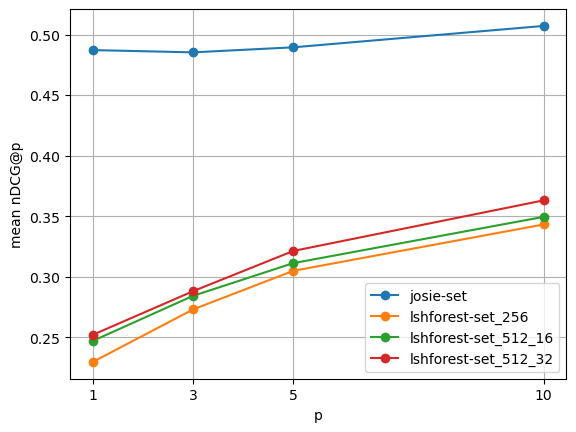

In [61]:
for row, label in zip(ndcg_pivot['mean', 'ndcg_p'].values, ndcg_pivot.index):
    plt.plot([1, 3, 5, 10], row, 'o-', label=f'{label[0]}-{label[1]}')
plt.xticks([1, 3, 5, 10], [1, 3, 5, 10])
plt.legend()
plt.xlabel("p")
plt.ylabel("mean nDCG@p")
plt.grid()

In [ ]:
query_id = 29938
silver_standard[query_id]

In [ ]:
data = [(am[0], am[1], group[(group['sloth_overlap'] != 0) & (group['difference_overlap'] != 0)]) for am, group in results.groupby(by=['algorithm', 'mode'])]

In [ ]:
df = results[(results['algorithm'] == 'josie') & (results['mode'] == 'bag') & (results['query_id'] == query_id)]
df

In [ ]:
df